# Experiment Setup 1: Cross Validation
 Name: Vinal Asodia <br>
 Username: va00191 <br>
 URN: 6539526
 
This experiment aims to apply K Fold cross validation to the base model and compare the performance to the base model.
 
#### Import Modules

In [93]:
import pickle
import pandas as pd
import numpy as np
import utils
import keras
import h5py
import nltk
from functools import lru_cache
from collections import Counter
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import average_precision_score, accuracy_score, roc_curve
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import RepeatedKFold, StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv1D, Dropout, Conv1D, GlobalMaxPooling1D, Embedding, LSTM, SpatialDropout1D
import matplotlib.pyplot as plt
%matplotlib inline

#### Define Constants

In [94]:
TRAIN_DATASET = "train.csv"
TEST_DATA = "test.csv"
TEST_LABELS = "test_labels.csv"
REDUNDANT_FIELDS = ["id"]
DATA_FIELD = ["comment_text"]
LABEL_FIELDS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

NUM_WORDS = 20000
EMBEDDING_DIM = 100
MAX_WORD = 200

BATCH_SIZE = 128
EPOCHS = 5

KFOLD_BATCH_SIZE = 256
KFOLD_EPOCHS = 2

N_SPLITS = 10
N_REPEATS = 1
RANDOM_STATE = None

#### Functions

In [95]:
def pickle_dataset(filename, dataset):
    file = open("{0}.pickle".format(filename),"wb")
    pickle.dump(dataset, file)
    file.close()

In [96]:
def round_pred(predictions):
    y_pred = [prediction.round() for prediction in predictions]
    
    return y_pred

In [97]:
def gen_confusion_matrix(y_true,y_pred):
    confusion_matrices={}

    for label_col in range(len(LABEL_FIELDS)):
        y_true_label = y_true[:, label_col]
        y_pred_label = y_pred[:, label_col]
        confusion_matrices[LABEL_FIELDS[label_col]] = confusion_matrix(y_pred=y_pred_label, y_true=y_true_label)
    
    return confusion_matrices

In [98]:
def plot_metrics(metrics):
    for label in range(0, len(LABEL_FIELDS)):
        for fold in range(0,N_SPLITS):
            plt.figure(label, figsize=(7,5))
            plt.plot(metrics[LABEL_FIELDS[label]][fold][0], metrics[LABEL_FIELDS[label]][fold][1], label='Fold {}'.format(fold+1))
            plt.title(LABEL_FIELDS[label])
            plt.legend()

In [99]:
def build_model(optimiser="adam"):
    model = Sequential()
    model.add(Embedding(len(corpus) + 1, 100, input_length=150))
    model.add(LSTM(40, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.5))
    model.add(Dense(30, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(6, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimiser, metrics=['accuracy'])

    return model


#### Read in preprocessed test and train datasets

In [100]:
train = pickle.load(open("balanced_train.pickle", "rb"))
test = pickle.load(open("balanced_test.pickle", "rb"))

tokenizer = Tokenizer(NUM_WORDS)
tokenizer.fit_on_texts(train)
corpus = tokenizer.word_index
reverse_corpus = dict(map(reversed, corpus.items()))

x_sequences_train = tokenizer.texts_to_sequences(train)
x_padded_train = keras.preprocessing.sequence.pad_sequences(x_sequences_train, maxlen= 150)
x_padded_train = np.array(x_padded_train)

y_train = pickle.load(open("balanced_train_labels.pickle", "rb"))

x_sequences_test = tokenizer.texts_to_sequences(test)
x_padded_test = keras.preprocessing.sequence.pad_sequences(x_sequences_test, maxlen= 150)
x_padded_test = np.array(x_padded_test)

y_test = pickle.load(open("balanced_test_labels.pickle", "rb"))

In [101]:
print(x_padded_train.shape)
print(y_train.shape)
print(x_padded_test.shape)
print(y_test.shape)

(78598, 150)
(78598, 6)
(10875, 150)
(10875, 6)


 #### Leave One Out Cross Validation (LOOCV)
 Originally LOOCV was included in this experiment. However, due to the large number of samples, the training time would be too long for the scope of this investigation. A workaround the training time, would be decreasing the number of epochs and drop more samples from the dataset. Doing so would jepordise the model's ability to generalise the dataset, so instead this experiment will focus on the other two techniques

#### KFold Cross Validation
Train Model

In [102]:
accr, losses = [], []
y_pred,y_true = [], []
precision_recall_curves = {"toxic":[],
                          "severe_toxic":[],
                          "obscene":[],
                          "threat":[],
                          "identity_hate":[],
                          "insult":[]}
roc_curves = {"toxic":[],
              "severe_toxic":[],
              "obscene":[],
              "threat":[],
              "identity_hate":[],
              "insult":[]}
modelKFOLD = build_model()
kf = RepeatedKFold(n_splits=N_SPLITS,n_repeats=N_REPEATS,random_state=RANDOM_STATE)

for train_index, val_index in kf.split(x_padded_train):
    X, X_val = x_padded_train[train_index], x_padded_train[val_index]
    y, y_val = y_train[train_index], y_train[val_index]
    modelKFOLD.fit(X, y, batch_size=KFOLD_BATCH_SIZE, epochs=KFOLD_EPOCHS)
    prediction = modelKFOLD.predict(X_val)
    
    
    # For each fold, calculate and store the true and false positive rate and
    # the precision and recall values for each label. These will be used to 
    # plot their corresponding graphs later on.
    fpr = dict()
    tpr = dict()
    precision = dict()
    recall = dict()
    
    for i in range(len(LABEL_FIELDS)):
        fpr[i], tpr[i], _ = roc_curve(y_val[:, i],
                                      prediction[:, i])
       
        precision[i], recall[i], _ = precision_recall_curve(y_val[:, i],
                                                            prediction[:, i])
        
        roc_curves[LABEL_FIELDS[i]].append([fpr[i], tpr[i]])
        precision_recall_curves[LABEL_FIELDS[i]].append([precision[i], recall[i]])
        
    y_pred.append(prediction)
    y_true.append(y_val)

Epoch 1/2
277/277 [==============================] - 334s 1s/step - loss: 0.2945 - accuracy: 0.4850
Epoch 2/2
277/277 [==============================] - 387s 1s/step - loss: 0.0948 - accuracy: 0.6988
Epoch 1/2
277/277 [==============================] - 424s 2s/step - loss: 0.0740 - accuracy: 0.8627
Epoch 2/2
277/277 [==============================] - 429s 2s/step - loss: 0.0675 - accuracy: 0.9201
Epoch 1/2
277/277 [==============================] - 401s 1s/step - loss: 0.0638 - accuracy: 0.9460
Epoch 2/2
277/277 [==============================] - 386s 1s/step - loss: 0.0603 - accuracy: 0.9603
Epoch 1/2
277/277 [==============================] - 388s 1s/step - loss: 0.0589 - accuracy: 0.9643
Epoch 2/2
277/277 [==============================] - 385s 1s/step - loss: 0.0555 - accuracy: 0.9696
Epoch 1/2
277/277 [==============================] - 383s 1s/step - loss: 0.0548 - accuracy: 0.9678
Epoch 2/2
277/277 [==============================] - 385s 1s/step - loss: 0.0522 - accuracy: 0.9720


In [103]:
# Due to long runtimes, save the roc and precision/recall curve values to avoid rerunning
pickle_dataset("kFoldROC",roc_curves)
pickle_dataset("kFoldPrecisionRecall",precision_recall_curves)

In [104]:
# Same logic for saving the predictions and true labels
pickle_dataset("kFoldYtrue",y_true)
pickle_dataset("kFoldYpred",y_pred)

In [105]:
# Finally save the model
modelKFOLD.save("kfold_model")

INFO:tensorflow:Assets written to: kfold_model\assets


In [106]:
# Load in precision/recall and roc curve values
# roc_curves = pickle.load(open("./cross_validation_experiment/kFoldROC.pickle", "rb"))
# precision_recall_curves = pickle.load(open("./cross_validation_experiment/kFoldPrecisionRecall.pickle", "rb"))
roc_curves = pickle.load(open(".//kFoldROC.pickle", "rb"))
precision_recall_curves = pickle.load(open("./kFoldPrecisionRecall.pickle", "rb"))

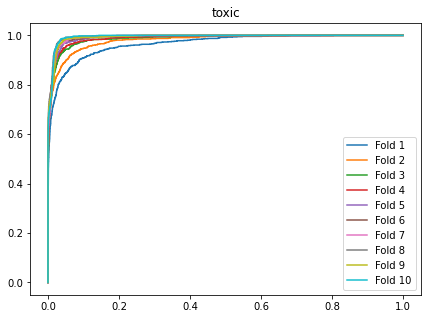

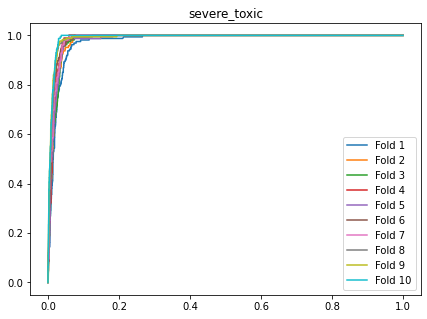

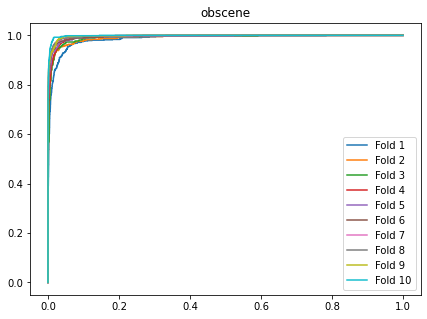

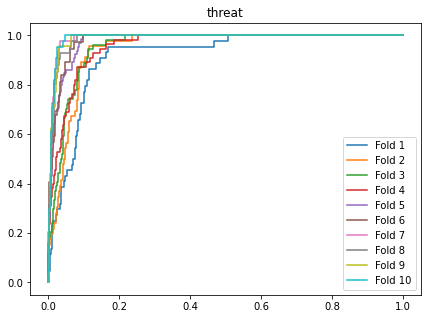

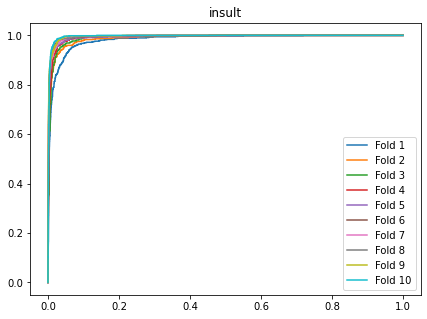

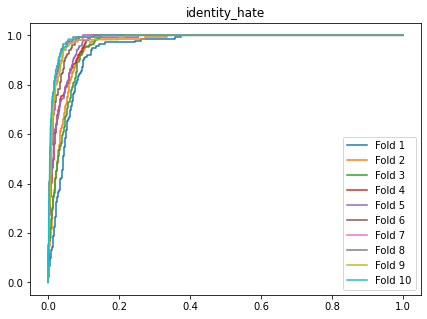

In [107]:
# Plot K Fold roc curve
plot_metrics(roc_curves)

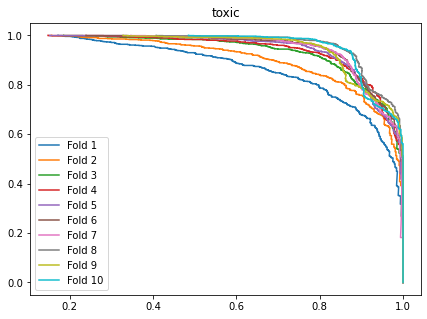

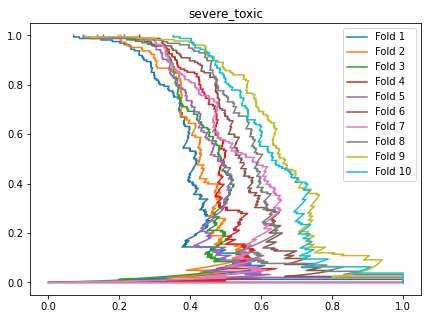

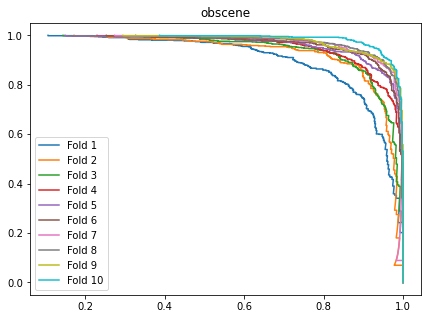

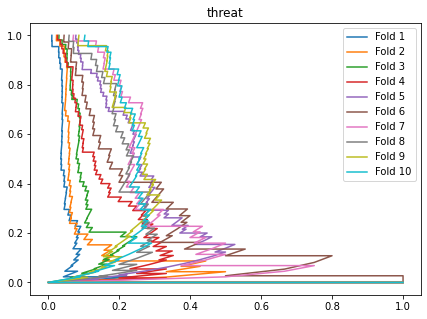

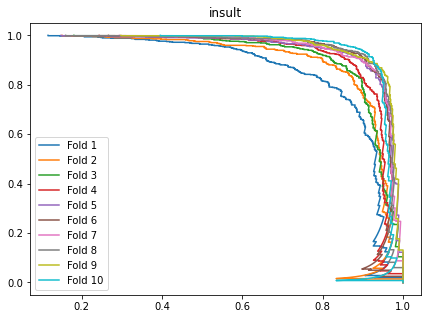

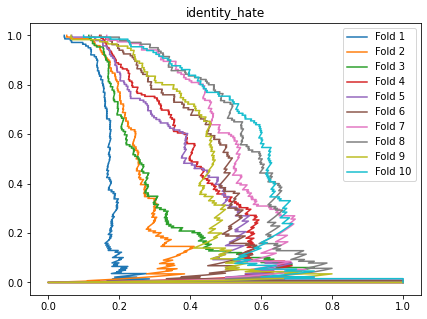

In [108]:
# Plot K Fold precision recall curve
plot_metrics(precision_recall_curves)

#### Discussion
Originally the number of epochs was set to 5 and the K Fold repeats was set to 3, with the intent to repeat the experiment 3 times and get the average result to be more robust. Through initial tries there was little variance in the repeated run, thus the experiment was redone with no repeats. This helped the runtime, but the models was overfitting, so the number of epochs was lowered to 2. Also in the original run, the model was trained with the original test dataset, due to the model's already great performance with predicting non-toxic comments, the model was retrained with a balanced test dataset. Interestingly, upon the rerun the precision/recall for "severe_toxic" comments had improved, "threat" comments had been negatively impacted and "identity_hate" comments stayed the same.

From the roc curves, it appears that the model has performed relatively well, with the categories with the lowest amount of samples (threat, identity_hate and severe_toxic) showing lower true/false positive rates. The model struggles to generalise the comments in these categories, which is evident from the precision/recall curves, where the recall sporadically increases and decrease over the folds. Compared to the base model, it appears the model has benefited from the repeated runs and cross validation, as the roc curves from the base model show that without cross validation, the model predicted the previously mentioned labels on a coin flip. 